In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import sys
from timeit import default_timer as timer
import math
from sklearn.linear_model import OrthogonalMatchingPursuit
np.set_printoptions(threshold=sys.maxsize)

from utils_flatland.optim import Model, training_loop, bruteForce
from utils_flatland.generateData import generateData, generateDataFast
from utils_flatland.helper import computeVisibility, pulse, matchFilt
from utils_flatland.shape import carving

In [2]:
#####################################################################
############################# PARAMETERS ############################
#####################################################################

# laser parameters
numSpots = 5
# las_x = np.linspace(0.5, 1.5, numSpots)
# las_y = 2-las_x # illumination wall 
las_x = 1.25 * np.ones(numSpots)
# las_y = np.linspace(0.25, 1.75)
las_y = np.linspace(2.25, 5.5, numSpots)
usePulse = True
pulseWidth = 1E-9 # only applicable for rectangular pulse
bin_width = 100E-12

# detector parameters
numPixels = 1
# det_x = np.linspace(-1.5, -0.5, numPixels)
# det_y = 2+det_x # detector wall
det_x = -1.25 * np.ones(numPixels)
# det_y = np.linspace(0.25, 1.75)
det_y = np.linspace(2.25, 5.5, numPixels)
detectorRes = 100E-12 # if this increases, need to subsample pulse

# noise parameters
pctNoise = 0
jitter = 0

# plotting parameters
plotData = True
plotSetup = True

# constant parameters
c = 3E8
    
# miscellaneous parameters
r1 = (np.max(det_x**2) + np.max(det_y**2))**0.5
r2 = (np.max(las_x**2) + np.max(las_y**2))**0.5
r3 = (np.max((las_x-det_x)**2) + np.max((las_y - det_y)**2))**0.5
maxDist =  r1 + r2 + r3 + 1
numBins = np.ceil((maxDist/c) / detectorRes).astype(int)
t = np.linspace(0, detectorRes * numBins, numBins)

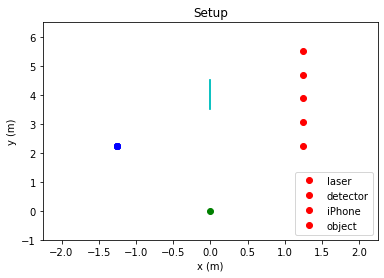

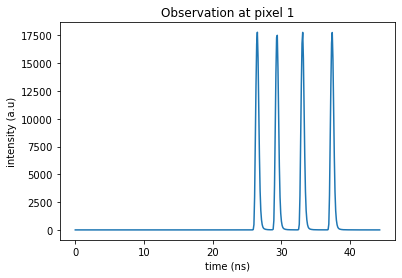

In [4]:
#####################################################################
################# GENERATE MULTIPLEXED MEASUREMENTS #################
#####################################################################
start = timer()

# hidden object location
# y_min = 0.75
# y_max = 1.25
x_min = 0
x_max = 0
y_min = 3.5
y_max = 4.5

# compute visibility matrix
vis_gt = computeVisibility(las_x, las_y, det_x, det_y, 0, y_min, y_max)
# vis_gt = np.where(np.random.rand(numPixels, numSpots) > 0.5, 1, 0)
# print(np.sum(vis_gt))

# compute multiplexed measurements
# observations, hists = generateData(las_x, las_y, det_x, det_y, vis_gt, numBins, 
#                                    plotData, plotSetup, x_min, x_max, y_min, y_max, usePulse, pctNoise, jitter, pulseWidth, t)
tofs_gt, observations, hists = generateDataFast(las_x, las_y, det_x, det_y, vis_gt, numBins, 
                                   plotData, plotSetup, x_min, x_max, y_min, y_max, usePulse, pctNoise, jitter, pulseWidth, t)

# _, a_test = pulse(0, numBins)
# tofs_gt += 100E-12 * np.argmax(a_test)



56.50825713644157
-6.377345366841084


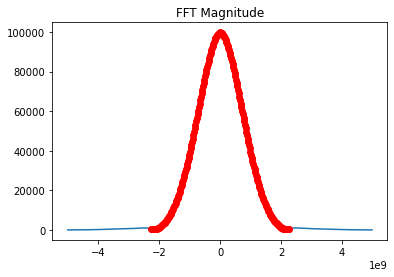

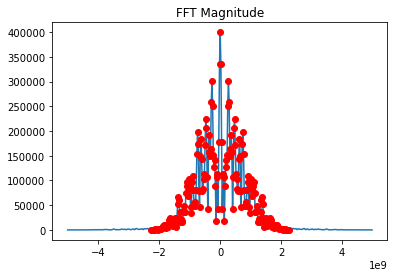

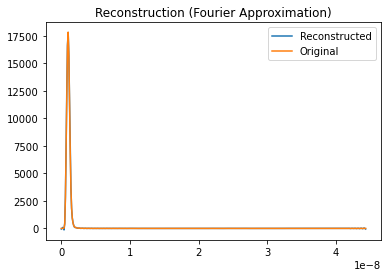

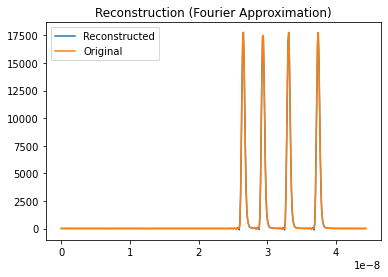

In [5]:
#####################################################################
################ COMPUTE FOURIER SERIES COEFFICIENTS ################
#####################################################################
def fourierSeries(t, a, M, T, f0, w0, f_samples, plotSpectrum):
    # compute FFT of signal
    a_fft = np.fft.fft(a)
    a_fft_shift = np.fft.fftshift(a_fft)
    f = np.fft.fftfreq(numBins, bin_width)
    f_shift = np.fft.fftshift(f)

    # determine which fourier coefficients to use
    diff = np.abs(np.reshape(f_samples, (2*M+1, 1)) - np.reshape(f_shift, (1, numBins)))
    idx = np.argmin(diff, axis=1)
    # p_hat = a_fft_shift[idx] * 0.45E-2

    # plot FFT of signal and fourier coefficients used
    if plotSpectrum:
        plt.figure()
        plt.title('FFT Magnitude')
        t0 = 0; t1 = numBins
        y = np.abs(a_fft_shift[t0:t1])
        plt.plot(f_shift[t0:t1], y)
        plt.plot(f_shift[idx], y[idx], 'ro')

    # compute fourier series approximation
    m = np.tile(np.reshape(np.linspace(-M, M, 2*M+1), (1, 2*M+1)), (numBins, 1))
    mw_0t = m * np.reshape(w0*t, (numBins, 1))
    comp_exps = np.exp(1j*mw_0t)
    p_hat = f0 * np.sum(np.reshape(a, (numBins, 1))*np.exp(-1j*mw_0t), axis=0) * bin_width
     
    return comp_exps, p_hat
    
# import original pulse
t, a = pulse(0, numBins)

# specify number of terms to use in fourier series
M = 100
plotSpectrum = True
T = (numBins-1)*bin_width
f0 = 1/T; w0 = 2*math.pi*f0
f_samples = f0 * np.reshape(np.linspace(-M, M, 2*M+1), (2*M+1, 1))

# fourier series approximation of signal
exps_p, p_hat = fourierSeries(t, a, M, T, f0, w0, f_samples, plotSpectrum)
exps_c, c_hat = fourierSeries(t, observations[0, :], M, T, f0, w0, f_samples, plotSpectrum)

reconst_p = np.real(np.sum(np.reshape(p_hat, (1, 2*M+1)) * exps_p, axis=1))
reconst_c = np.real(np.sum(np.reshape(c_hat, (1, 2*M+1)) * exps_c, axis=1))

# plot reconstructed fourier series signal
plt.figure()
plt.title('Reconstruction (Fourier Approximation)')
plt.plot(t, reconst_p)
plt.plot(t, a)
plt.legend(['Reconstructed', 'Original'])
print(np.sum(a-reconst_p))

plt.figure()
plt.title('Reconstruction (Fourier Approximation)')
plt.plot(t, reconst_c)
plt.plot(t, observations[0, :])
plt.legend(['Reconstructed', 'Original'])
print(np.sum(observations[0, :]-reconst_c))

In [60]:
w0 *  (1E-10) * 180 / (math.pi) 

0.8126410835214447

In [61]:
2*math.pi / w0

4.43e-08

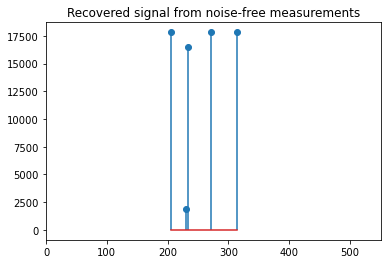

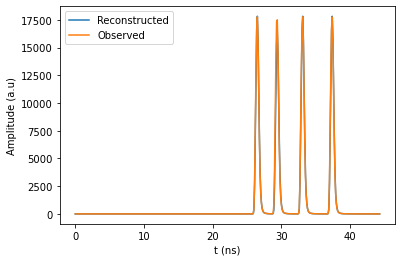

In [39]:
#####################################################################
####################### DETERMINE VISIBLE TOFs ######################
#####################################################################

observations = np.reshape(observations, (numBins, 1))
# construct dictionary matrix P
t_min = 5; t_max = 60 # in nanoseconds
L = int(1 + (t_max - t_min) / 0.1)
shifts = 1E-9 * np.linspace(t_min, t_max, L)
P = np.zeros((numBins, L))
for i in range(L):
    _, a = pulse(shifts[i], numBins)
    P[:, i] = np.array(a) / np.max(a)
    
# compute K-sparse representation
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=numSpots, normalize=False)
omp.fit(P, observations)
tof_preds = shifts[idx_r]

# plot sparse recovery
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.figure()
plt.xlim(0, L)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

# plot reconstructed sparse signal
reconst = np.zeros(numBins)
for i in idx_r:
    if coef[i] > 5000:
        reconst += coef[i] * P[:, i]
plt.figure()
plt.plot(1E9*t, reconst)
plt.plot(1E9*t, observations)
plt.xlabel('t (ns)')
plt.ylabel('Amplitude (a.u)')
plt.legend(['Reconstructed', 'Observed'])

In [47]:
#####################################################################
########### RECONSTRUCT VISIBLE MATRIX FROM EXTRACTED TOFs ##########
#####################################################################
def determineViableSources(det_locs, las_locs, tof, thresh, c, hiddenSpace):
    # INPUTS:
    #    det_locs = numPixels x 2
    #    las_locs = numSpots x 2
    #    tof = numPixels x k (k = # of spots)
    #    coeff = numPixels x k (k = # of spots)
    # OUTPUTS:
    #    heatmap = 
    
    # constant variables
    numPixels = det_locs.shape[0]
    numSpots = las_locs.shape[0]
    
    det_x = np.tile(np.reshape(det_locs[:, 0], (numPixels, 1)), (1, numSpots)) # numPixels x numSpots
    det_y = np.tile(np.reshape(det_locs[:, 1], (numPixels, 1)), (1, numSpots))
    
    las_x = np.tile(np.reshape(las_locs[:, 0], (1, numSpots)), (numPixels, 1)) # numPixels x numSpots
    las_y = np.tile(np.reshape(las_locs[:, 1], (1, numSpots)), (numPixels, 1))
    
    # compute tofs corresponding to each detector-laser pair
    r1 = (las_x**2 + las_y**2)**0.5
    r2 = (det_x**2 + det_y**2)**0.5
    r3 = ((det_x-las_x)**2 + (det_y-las_y)**2)**0.5
    tofs = (r1 + r2 + r2) / c
    
    # 
    
    return idxs


In [46]:
las_locs = np.hstack((np.reshape(las_x, (numSpots, 1)), np.reshape(las_y, (numSpots, 1))))
det_locs = np.hstack((np.reshape(det_x, (numPixels, 1)), np.reshape(det_y, (numPixels, 1))))

(1, 2)


In [31]:
# #####################################################################
# ########################## SOLVE FOR PHASES #########################
# #####################################################################

# def OMP(D, y, k):
#     M, L = D.shape
#     cur_state = np.reshape(y, (M, 1))
#     x = np.zeros((L, 1)) + 0j
#     n = 0
#     for i in range(k):
#         corrs = np.abs(np.sum(D * np.conjugate(cur_state), axis=0))
#         idx = np.argmax(corrs)
#         x[idx] = np.abs(corrs[idx])
#         cur_state -= corrs[idx] * np.reshape(D[:, idx], (M, 1))
#     return x

# start = timer()
# # create dictionary matrix
# L = 500
# ml = c_hat / p_hat; ml = ml[M+1:]
# D = np.reshape(np.linspace(0, 2*math.pi, L), (1, L)) * np.reshape(np.linspace(1, M, M), (M, 1))
# D = np.exp(-1j*D)

# gamma = OMP(D, ml, numSpots)
# end = timer()
# print(end-start)
# # import sympy

# # l, z = sympy.symbols('l, z')
# # z_transf = sympy.Sum(ml * z**-l, (l, -M, M))
# # z_transf

In [14]:
# plt.figure(figsize=(18, 6))
# x = np.linspace(1, numSpots, numSpots)
# y = np.linspace(1, numPixels, numPixels)

# plt.subplot(1, 3, 1)
# plt.title('V (Ground Truth)')
# plt.xlabel('Source #')
# plt.ylabel('Pixel #')
# plt.contourf(x, y, vis_gt)
# plt.colorbar()

# plt.subplot(1, 3, 2)
# plt.title('V (Reconstructed)')
# plt.xlabel('Source #')
# plt.ylabel('Pixel #')
# plt.contourf(x, y, v_reconst)
# plt.colorbar()

# plt.subplot(1, 3, 3)
# plt.title('Error in Visibility Matrix (vis_gt - v_reconst)')
# vis_errors = vis_gt - v_reconst
# plt.xlabel('Source #')
# plt.ylabel('Pixel #')
# plt.contourf(x, y, vis_errors)
# plt.colorbar()

In [30]:
# # plot for all entries
# a = np.sum(vis_gt, 1)
# b = np.sum(v_reconst, 1)
# min_err = min(np.min(a), np.min(b))
# max_err = max(np.max(a), np.max(b))
# x = np.linspace(min_err, max_err); y = x
# plt.figure()
# plt.plot(a, b, 'o')
# plt.plot(x, y, 'r')
# plt.legend(['experimental', 'ideal'])
# plt.xlabel('# of "on" sources (GT)')
# plt.ylabel('# of "on" sources (estimated)')
# plt.title('Comparison of # of "on" sources')
# print(np.abs(a-b) * (np.abs(a-b) > 5))

In [ ]:
# #####################################################################
# #################### COMPUTE SHAPE USING CARVING ####################
# #####################################################################

# # carving parameters
# pixelSize = 0.02# in meters
# xMin = -1.25; xMax = 1.25
# eta = 0.01; zeta = 0.85; p_e = 0.5; p_o = 0.5

# # compute and plot heatmap
# xlocs, ylocs, heatmap, naiveMap, occupied_prob, unoccupied_prob = carving(v_reconst, las_x, las_y, det_x, det_y, 
#                                                                           pixelSize, xMin, xMax, eta, zeta, p_e, p_o)
# heatmap_mod = heatmap * ((unoccupied_prob != 0 )| (occupied_prob != 0))

# plt.figure(figsize=(6,6))
# plt.title('Probabilistic Space Carving')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# plt.contourf(xlocs, ylocs, heatmap_mod)
# plt.plot(np.zeros(100), np.linspace(y_min, y_max, 100), 'r')
# plt.legend(['Ground Truth'])
# plt.colorbar()

# plt.figure(figsize=(6,6))
# plt.title('Naive Space Carving')
# # plt.gray()
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# plt.contourf(xlocs, ylocs, naiveMap)
# plt.plot(np.zeros(100), np.linspace(y_min, y_max, 100), 'r')
# plt.legend(['Ground Truth'])
# plt.colorbar()

# plt.figure(figsize=(6,6))
# plt.title('Unoccupied Probability')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# plt.contourf(xlocs, ylocs, unoccupied_prob)
# plt.plot(np.zeros(100), np.linspace(y_min, y_max, 100), 'r')
# plt.legend(['Ground Truth'])
# plt.colorbar()

# plt.figure(figsize=(6,6))
# plt.title('Occupied Probability')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# plt.contourf(xlocs, ylocs, occupied_prob)
# plt.plot(np.zeros(100), np.linspace(y_min, y_max, 100), 'r')
# plt.legend(['Ground Truth'])
# plt.colorbar()